In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import csv
from math import floor

In [2]:
steps = ['data_loading','ratings_prep','movies_prep','movies_ratings_join','subsets_stats','ratings_array','model_train_eval']
path = 'movie_lens_stats'
GB = 1073741824

In [3]:
# plt.rcParams['figure.dpi'] = 300

In [4]:
def mavg(arr, ws):
  i = 0
  ma = []
  while i < len(arr) - ws + 1:
      w = arr[i : i + ws]
      wa = sum(w) / ws
      ma.append(wa)
      i += 1

  return ma

### plot functions

In [5]:
# data_loading = (0,'80_1','60,8',10,10)

def plot_2_2(step, single_conf, distr_conf, single_mavg, distr_mavg):

  single = pd.read_csv(f'./{path}/{steps[step]}/{steps[step]}_{single_conf}.csv', header=0)
  distr = pd.read_csv(f'./{path}/{steps[step]}/{steps[step]}_{distr_conf}.csv', header=0)

  single_ram, single_cpu = single['RAM Usage']/GB, single['CPU Usage (%)']
  distr_ram, distr_cpu = distr['RAM Usage']/GB, distr['CPU Usage (%)']
  single_time = single['Time'].iloc[-1]-single['Time'].iloc[0]
  distr_time = distr['Time'].iloc[-1]-distr['Time'].iloc[0]

  print(f'1 worker loading data {single_time:.2f}')
  print(f'8 workers loading data {distr_time:.2f}')
  single_time = round(single_time)
  distr_time = round(distr_time)
  # print(single_time, distr_time)

  single_cpu = mavg(list(single_cpu), single_mavg)
  distr_cpu = mavg(list(distr_cpu), distr_mavg)

  # Create a figure and subplots
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))
  plt.subplots_adjust(hspace=0.4, wspace=0.4)

  # data
  axs[0, 0].plot(np.linspace(0, single_time, len(single_ram)), single_ram, color='royalblue', linewidth=1.0) # bytes to GB
  axs[0, 1].plot(np.linspace(0, distr_time, len(distr_ram)), distr_ram, color='royalblue', linewidth=1.0)
  axs[1, 0].plot(np.linspace(0, single_time, len(single_cpu)), single_cpu, color='mediumseagreen', linewidth=1.0)
  axs[1, 1].plot(np.linspace(0, distr_time, len(distr_cpu)), distr_cpu, color='mediumseagreen', linewidth=1.0)

  # titles
  axs[0, 0].set_title('1 worker')
  axs[0, 1].set_title('8 workers')
  axs[1, 0].set_title('1 worker')
  axs[1, 1].set_title('8 workers')
  # axis top
  axs[0, 0].set_ylabel("RAM usage (GB)", fontsize=10)
  axs[0, 1].set_ylabel("RAM usage (GB)", fontsize=10)
  axs[0, 0].set_xlabel("Time (s)", fontsize=10)
  axs[0, 1].set_xlabel("Time (s)", fontsize=10)
  # axis below
  axs[1, 0].set_ylabel("CPU usage (%)", fontsize=10)
  axs[1, 1].set_ylabel("CPU usage (%)", fontsize=10)
  axs[1, 0].set_xlabel("Time (s)", fontsize=10)
  axs[1, 1].set_xlabel("Time (s)", fontsize=10)
  # axis limit
  min_lim, max_lim = min(pd.concat([single_ram, distr_ram])), max(pd.concat([single_ram, distr_ram]))
  axs[0, 0].set_ylim(min_lim, max_lim)
  axs[0, 1].set_ylim(min_lim, max_lim)
  axs[1, 0].set_ylim(0, 100)
  axs[1, 1].set_ylim(0, 100)

  for axs in axs.flat: axs.grid(axis='y', linestyle='--', alpha=0.5)
  plt.show()

In [6]:
def plot_3_2(step, train_plot, single_cpu_mavg, single_ram_mavg, distr_cpu_mavg, distr_ram_mavg):

  data_list = []
  plot_names = []
  for i in range(60,90,10):
    for j in range(1,9,7):
      if train_plot: data_list.append(pd.read_csv(f'./{path}/{steps[step]}/model_train_{i}_{j}.csv', header=0))
      else: data_list.append(pd.read_csv(f'./{path}/{steps[step]}/{steps[step]}_{i}_{j}.csv', header=0))
      plot_names.append(f'{j}w 50-{i}')

  ram_lims = []
  for lim in range(0, len(data_list), 2):
    single = data_list[lim]['RAM Usage']/GB
    distr = data_list[lim+1]['RAM Usage']/GB
    min_lim, max_lim = min(pd.concat([single, distr])), max(pd.concat([single, distr]))
    ram_lims.append([min_lim, max_lim])


  time_data = []
  for plot_name, data in zip(plot_names, data_list):
    total_time = data['Time'].iloc[-1]-data['Time'].iloc[0]
    time_data.append(total_time)
    print(f'{plot_name} total time : {total_time:.2f}')


  fig, axs = plt.subplots(3, 2, figsize=(10, 10))
  plt.subplots_adjust(hspace=0.7, wspace=0.4)

  for plot_number in range(len(data_list)):

    plotting_data = data_list[plot_number]
    if plot_number % 2 == 0:
      ram_usage = mavg(list(plotting_data['RAM Usage']/GB), single_ram_mavg)
      cpu_usage = mavg(list(plotting_data['CPU Usage (%)']), single_cpu_mavg)
    else:
      ram_usage = mavg(list(plotting_data['RAM Usage']/GB), distr_ram_mavg)
      cpu_usage = mavg(list(plotting_data['CPU Usage (%)']), distr_cpu_mavg)

    plt.subplot(3, 2, plot_number+1)
    # RAM PLOT
    plt.plot(np.linspace(0, time_data[plot_number], len(ram_usage)), ram_usage, color='royalblue', linewidth=1.0) #, color='green', label='RAM Usage (GB)')
    plt.ylabel('RAM Usage (GB)', color='royalblue')
    plt.xlabel('Time (s)')
    plt.ylim(ram_lims[floor(plot_number/2)])
    if train_plot:plt.ylim(ram_lims[floor(plot_number/2)][0],ram_lims[floor(plot_number/2)][1]+1)

    plt.twinx()
    # CPU PLOT
    plt.plot(np.linspace(0, time_data[plot_number], len(cpu_usage)), cpu_usage, color='mediumseagreen', linewidth=1.0)
    plt.ylabel('CPU Usage (%)', color='seagreen')
    plt.ylim(0,100)
    plt.title(plot_names[plot_number])
  plt.show()

### PLOTS

1 worker loading data 32.46
8 workers loading data 10.89


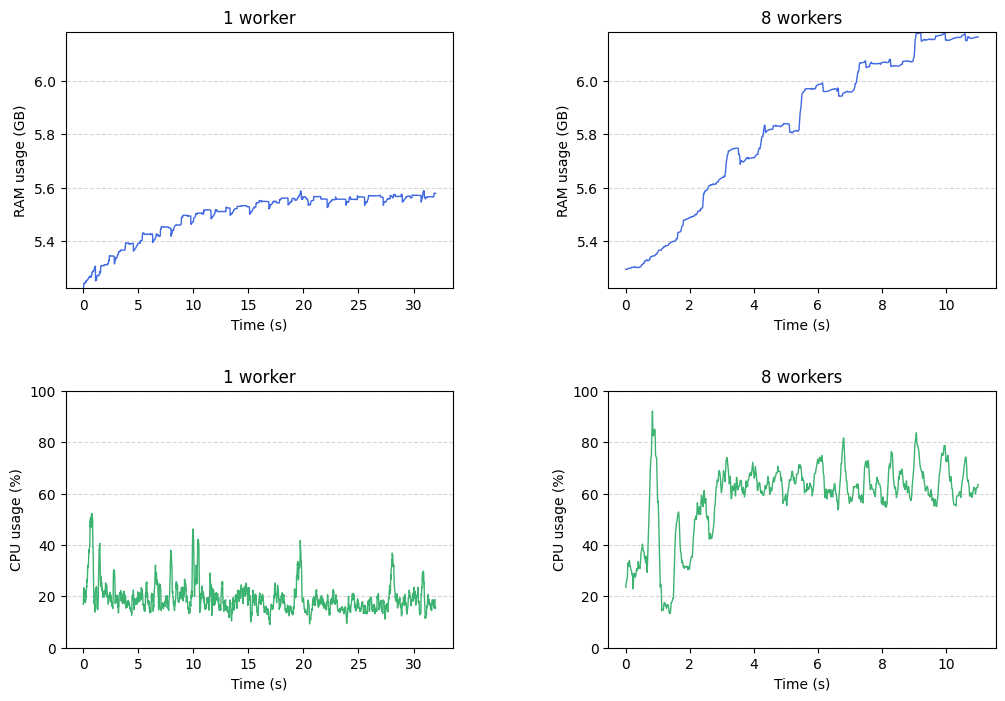

In [7]:
# 0 data loading
plot_2_2(step=0,
         single_conf='80_1',
         distr_conf='60_8',
         single_mavg=10,
         distr_mavg=10)

1 worker loading data 90.03
8 workers loading data 25.80


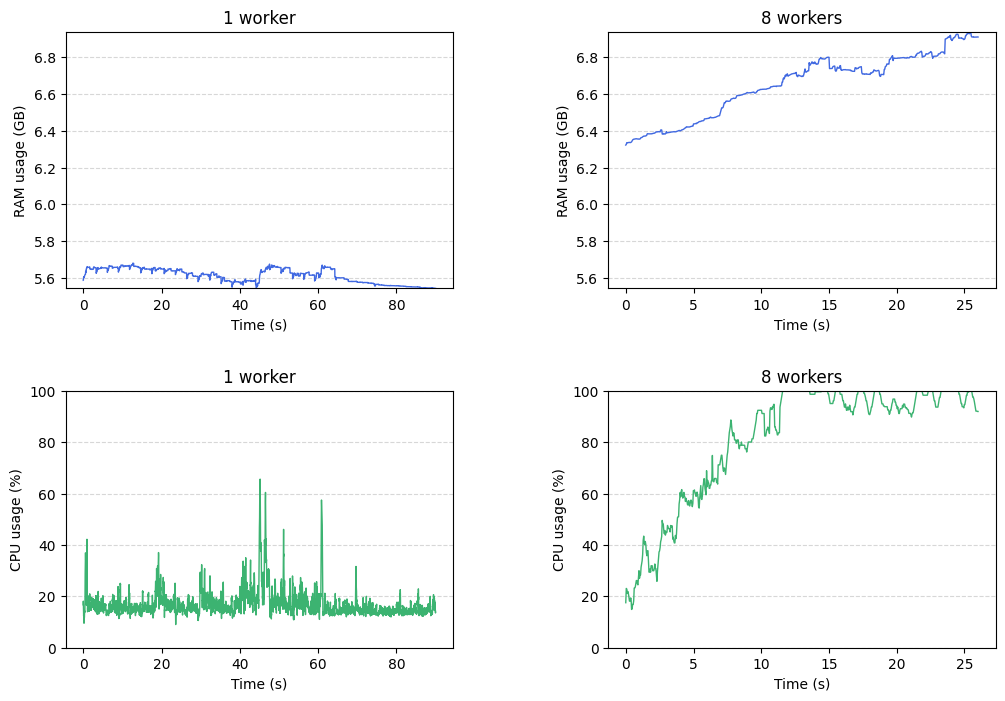

In [8]:
# 1 ratings prep
plot_2_2(step=1,
         single_conf='80_1',
         distr_conf='60_8',
         single_mavg=10,
         distr_mavg=10)

1w 50-60 total time : 2.03
8w 50-60 total time : 1.64
1w 50-70 total time : 2.03
8w 50-70 total time : 1.56
1w 50-80 total time : 2.31
8w 50-80 total time : 1.53


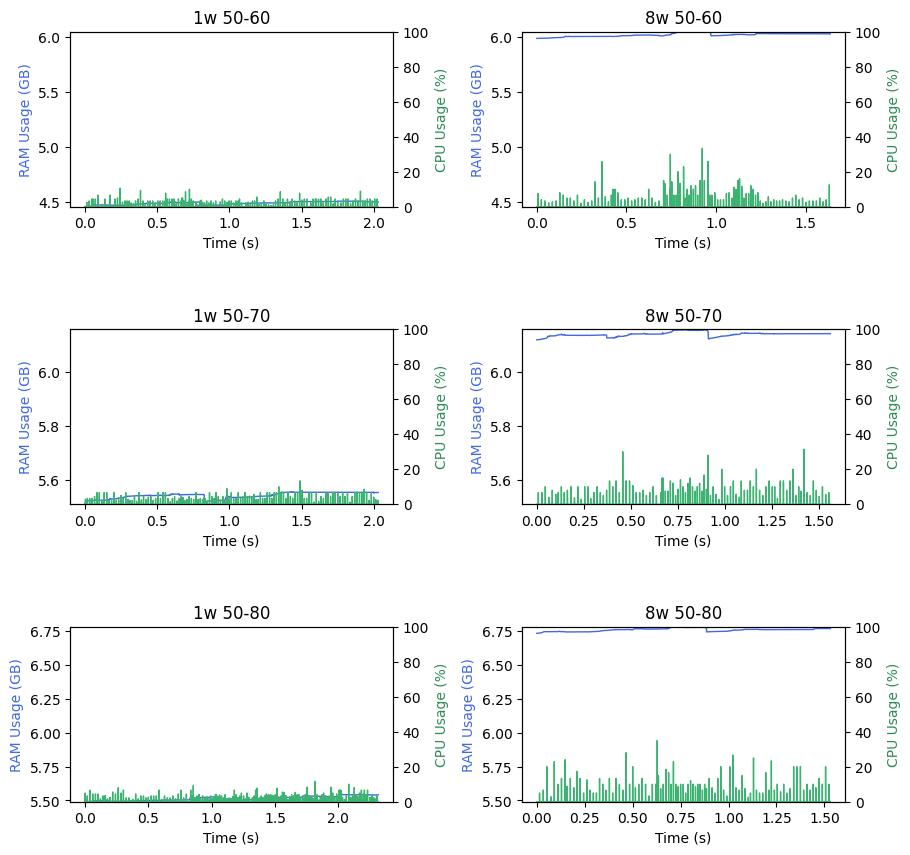

In [9]:
# 2 movie prep
plot_3_2(step=2,
         train_plot=False,
         single_cpu_mavg=15,
         single_ram_mavg=10,
         distr_cpu_mavg=5,
         distr_ram_mavg=10)

1w 50-60 total time : 128.34
8w 50-60 total time : 55.41
1w 50-70 total time : 140.99
8w 50-70 total time : 63.59
1w 50-80 total time : 161.48
8w 50-80 total time : 78.11


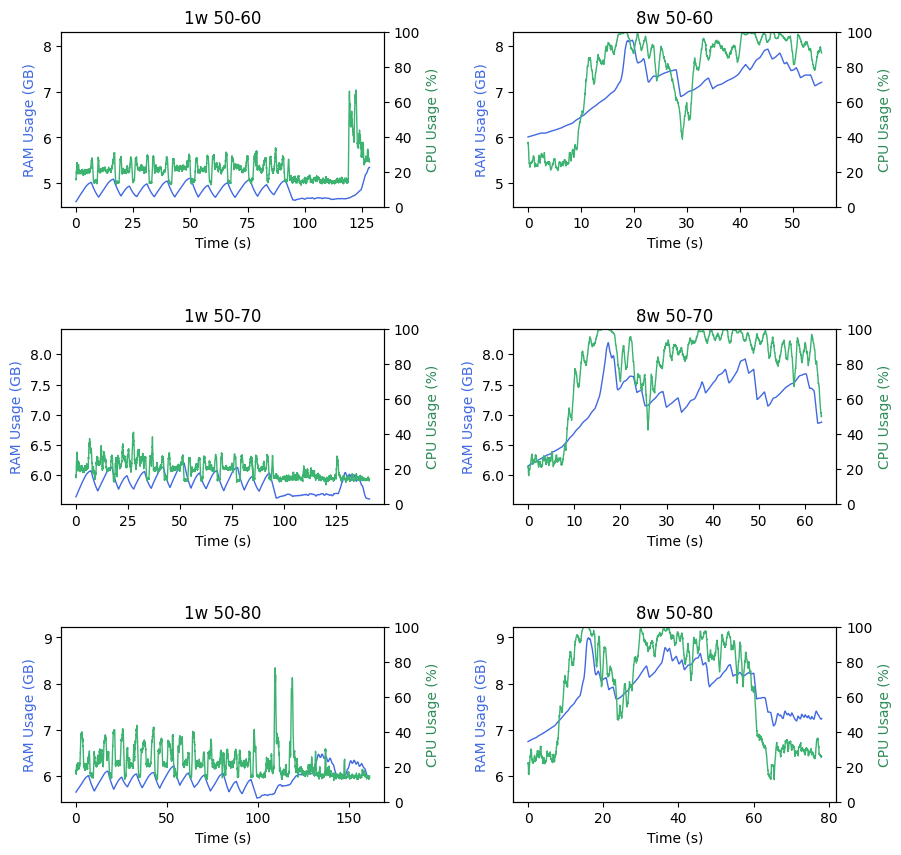

In [10]:
# 3 movies ratings join
plot_3_2(step=3,
         train_plot=False,
         single_cpu_mavg=30,
         single_ram_mavg=200,
         distr_cpu_mavg=30,
         distr_ram_mavg=30)

1w 50-60 total time : 43.16
8w 50-60 total time : 46.71
1w 50-70 total time : 50.28
8w 50-70 total time : 45.41
1w 50-80 total time : 35.86
8w 50-80 total time : 41.93


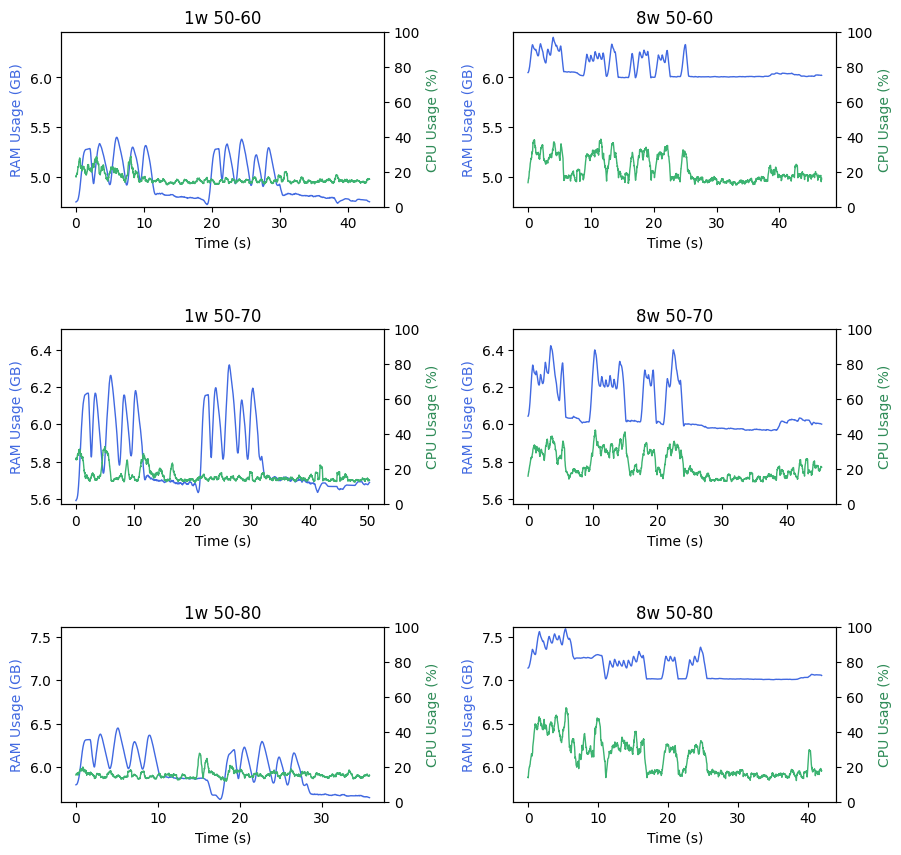

In [11]:
# 4 subsets stats
plot_3_2(step=4,
         train_plot=False,
         single_cpu_mavg=30,
         single_ram_mavg=30,
         distr_cpu_mavg=30,
         distr_ram_mavg=30)

1w 50-60 total time : 110.00
8w 50-60 total time : 29.70
1w 50-70 total time : 155.00
8w 50-70 total time : 56.20
1w 50-80 total time : 165.30
8w 50-80 total time : 81.60


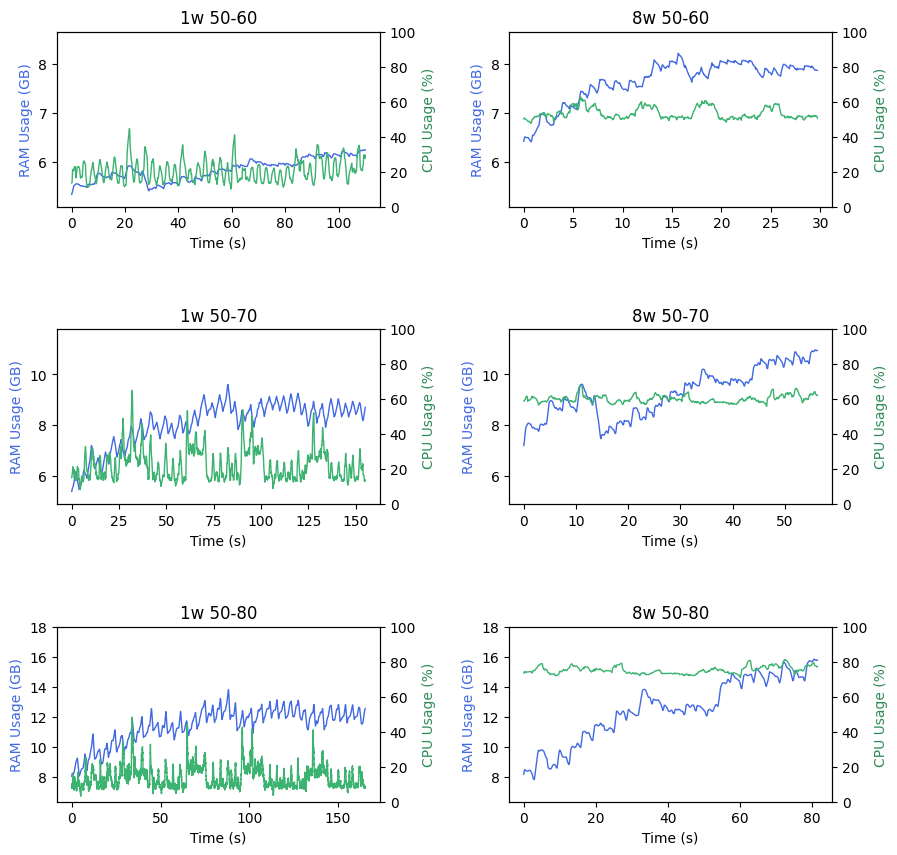

In [12]:
# 5 ratings array
plot_3_2(step=5,
         train_plot=False,
         single_cpu_mavg=15,
         single_ram_mavg=30,
         distr_cpu_mavg=15,
         distr_ram_mavg=15)

1w 50-60 total time : 263.85
8w 50-60 total time : 52.65
1w 50-70 total time : 751.68
8w 50-70 total time : 150.29
1w 50-80 total time : 1877.52
8w 50-80 total time : 311.00


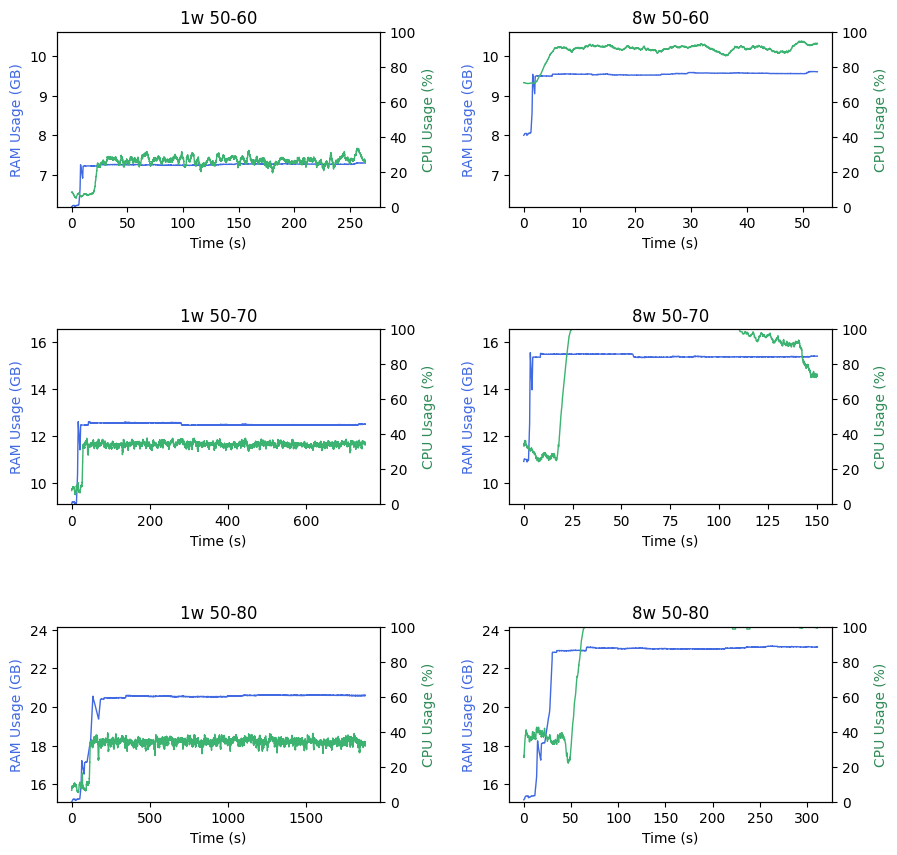

In [13]:
# 6 model train
plot_3_2(step=6,
         train_plot=True,
         single_cpu_mavg=150,
         single_ram_mavg=1,
         distr_cpu_mavg=150,
         distr_ram_mavg=1)

### model evaluation

In [14]:
step = 6
eval_data = []
eval_names = []
for i in range(60,90,10):
  for j in range(1,9,7):
    eval_data.append(pd.read_csv(f'./{path}/{steps[step]}/model_eval_{i}_{j}.csv', header=0))
    eval_names.append(f'{i}_{j}')

In [15]:
for name, data in zip(eval_names, eval_data):
  # if name[-1] == '8':
    train_mse = data["train_mse"][0]
    test_mse = data["test_mse"][0]
    print(name, f'\ttrain_mse: {train_mse:.6f}', f'\ttest_mse: {test_mse:.6f}', f'\ttrain_test_div: {test_mse/train_mse*100-100:.2f} %' )
    # print(name, f'\ttrain_mse: {train_mse}', f'\ttest_mse: {test_mse}', f'\ttrain_test_div: {test_mse/train_mse*100-100:.2f} %' )

60_1 	train_mse: 0.000345 	test_mse: 0.000471 	train_test_div: 36.83 %
60_8 	train_mse: 0.001241 	test_mse: 0.001254 	train_test_div: 1.02 %
70_1 	train_mse: 0.000451 	test_mse: 0.000501 	train_test_div: 11.00 %
70_8 	train_mse: 0.001014 	test_mse: 0.001040 	train_test_div: 2.61 %
80_1 	train_mse: 0.000479 	test_mse: 0.000559 	train_test_div: 16.69 %
80_8 	train_mse: 0.000604 	test_mse: 0.000914 	train_test_div: 51.27 %


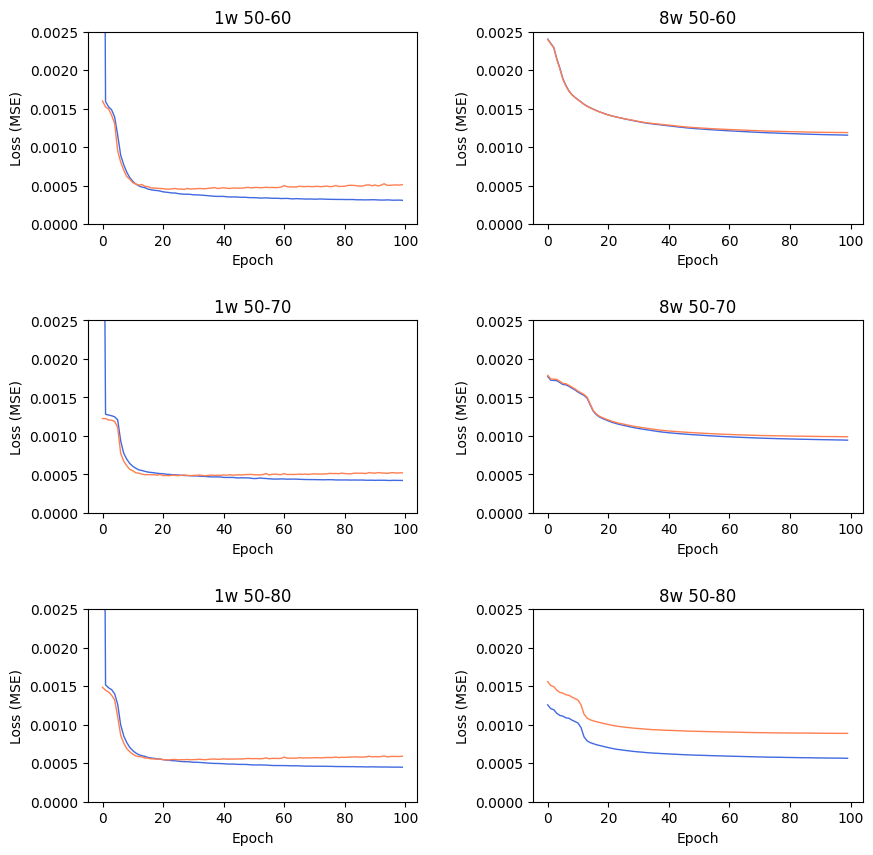

In [16]:
confs = ['60_1','60_8','70_1','70_8','80_1','80_8']

fig, axs = plt.subplots(3,2,figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.35)

for i,conf in enumerate(confs):

  train = np.load(f'./losses/train_losses_{conf}.npy')
  val = np.load(f'./losses/val_losses_{conf}.npy')
  plt.subplot(3,2,i+1)
  plt.plot(train, color='royalblue', linewidth=1.0)
  plt.plot(val, color='coral', linewidth=1.0)
  plt.ylim(0,0.0025)
  plt.ylabel('Loss (MSE)')
  plt.xlabel('Epoch')
  plt.title(f'{conf[-1]}w 50-{conf[:2]}')

plt.show()